In [ ]:
import pandas as pd
import tensorflow
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Model definition
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#neural network model using Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
 # Define the model
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation='relu'))  # Convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling layer
model.add(Dropout(0.4))  # Dropout layer
model.add(Flatten())  # Flatten layer
model.add(Dense(128, activation='relu'))  # Dense (fully connected) layer
model.add(Dropout(0.4))  # Another dropout layer
model.add(Dense(7, activation='sigmoid'))  # Output layer with sigmoid activation for multi-label classification

In [ ]:
#to read a CSV file and extract certain columns
import pandas as pd

# Data preprocessing
data = pd.read_csv("/content/drive/MyDrive/Mini_project24/HAM10000_metadata.csv")
data['image_full_name'] = data['image_id'] + '.jpg'
X = data[['image_full_name', 'dx', 'lesion_id']]


In [ ]:
X.sample(5)

,image_full_name,dx,lesion_id
4088,ISIC_0026317.jpg,nv,HAM_0004918
5709,ISIC_0028320.jpg,nv,HAM_0005577
7923,ISIC_0033441.jpg,nv,HAM_0005601
2424,ISIC_0025612.jpg,vasc,HAM_0002177
7080,ISIC_0032242.jpg,nv,HAM_0003951


In [ ]:
# splitting the data into training, validation, and test sets using train_test_split from scikit-learn.

#When you use pop() on X, it modifies X by removing the 'dx' column
#and assigning it to Y, so subsequent operations on X will not include the 'dx' column.
from sklearn.model_selection import train_test_split

# Separate the target variable 'dx' from the features
Y = X.pop('dx').to_frame()

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.17, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.17, random_state=42)


In [ ]:
#to combine features and labels for training, validation, and test datasets.
train = pd.concat([X_train, Y_train], axis=1)
val = pd.concat([X_val, Y_val], axis=1)
test = pd.concat([X_test, Y_test], axis=1)


In [ ]:
#to encode the labels in the validation set (val['dx']),
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['dx'])  # Assuming you want to fit the encoder on training data
name_as_indexes_train = encoder.transform(train['dx'])  # Transforming training labels
name_as_indexes_val = encoder.transform(val['dx'])  # Transforming validation labels
train['label'] = name_as_indexes_train
val['label'] = name_as_indexes_val


In [ ]:
# to fit the encoder on the training data and then use the same encoder to transform both training and test data to maintain consistency.
from sklearn.preprocessing import LabelEncoder

# Assuming you've already fitted the encoder on the training data
name_as_indexes_test = encoder.transform(test['dx'])
test['label'] = name_as_indexes_test


In [ ]:
!pip install keras-preprocessing


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
#ImageDataGenerator object for data augmentation in Keras.
from keras_preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     zoom_range=0.1,
                                     width_shift_range=0.0,
                                     height_shift_range=0.0)

# For validation and test, only rescale the pixel values
val_test_generator = ImageDataGenerator(rescale=1./255)


In [ ]:
import os

# Remove rows with invalid image filenames
valid_train = train[train['image_full_name'].apply(lambda x: os.path.exists(os.path.join("/content/drive/MyDrive/Dataset/HAM10000_images_part_1", x)))]

# Update train_data with the cleaned DataFrame
train_data = train_generator.flow_from_dataframe(dataframe=valid_train,
                                                 x_col="image_full_name",
                                                 y_col="dx",
                                                 batch_size=32,
                                                 directory="/content/drive/MyDrive/Dataset/HAM10000_images_part_1",
                                                 shuffle=True,
                                                 class_mode="categorical",
                                                 target_size=(224,224))


Found 3451 validated image filenames belonging to 7 classes.


In [ ]:
test_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     zoom_range=0.1,
                                     width_shift_range=0.0,
                                     height_shift_range=0.0)

In [ ]:
import os
from keras_preprocessing.image import ImageDataGenerator

# Remove rows with invalid image filenames
valid_test = test[test['image_full_name'].apply(lambda x: os.path.exists(os.path.join("/content/drive/MyDrive/Dataset/HAM10000_images_part_1", x)))]

# Update test_data with the cleaned DataFrame
test_data = test_generator.flow_from_dataframe(dataframe=valid_test,
                                                x_col="image_full_name",
                                                y_col="dx",
                                                batch_size=1,
                                                directory="/content/drive/MyDrive/Dataset/HAM10000_images_part_1",
                                                shuffle=False,
                                                class_mode="categorical",
                                                target_size=(224,224))


Found 836 validated image filenames belonging to 7 classes.


In [ ]:
import os
from keras_preprocessing.image import ImageDataGenerator

# Remove rows with invalid image filenames
valid_val = val[val['image_full_name'].apply(lambda x: os.path.exists(os.path.join("/content/drive/MyDrive/Dataset/HAM10000_images_part_1", x)))]

# Update val_data with the cleaned DataFrame
val_data = test_generator.flow_from_dataframe(dataframe=valid_val,
                                              x_col="image_full_name",
                                              y_col="dx",
                                              directory="/content/drive/MyDrive/Dataset/HAM10000_images_part_1",
                                              batch_size=64,
                                              shuffle=False,
                                              class_mode="categorical",
                                              target_size=(224,224))


Found 712 validated image filenames belonging to 7 classes.


In [ ]:
#ReduceLROnPlateau callback to adjust the learning rate during training is correct

from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=.5,min_lr=0.0001)

In [ ]:
from keras.optimizers import SGD

sgd = SGD(learning_rate=0.01, clipvalue=0.5)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))  # Assuming 7 classes for classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(x=train_data,
                    steps_per_epoch=train_data.samples // train_data.batch_size,
                    validation_data=val_data,
                    validation_steps=val_data.samples // val_data.batch_size,
                    verbose=1,
                    epochs=10,
                    callbacks=[learning_control])


Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 1.0672 - accuracy: 0.6786

107/107 [==============================] - 1128s 10s/step - loss: 1.0672 - accuracy: 0.6786 - val_loss: 0.8902 - val_accuracy: 0.6918 - lr: 0.0010
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.8866 - accuracy: 0.6973

107/107 [==============================] - 90s 846ms/step - loss: 0.8866 - accuracy: 0.6973 - val_loss: 0.8422 - val_accuracy: 0.7060 - lr: 0.0010
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.8386 - accuracy: 0.7037

107/107 [==============================] - 90s 838ms/step - loss: 0.8386 - accuracy: 0.7037 - val_loss: 0.8200 - val_accuracy: 0.6932 - lr: 0.0010
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.8133 - accuracy: 0.7175

107/107 [==============================] - 96s 901ms/step - loss: 0.8133 - accuracy: 0.7175 - val_loss: 0.8184 - val_accuracy: 0.6974 - lr: 0.0010
Epoch 5/10
107/107 [==============================] - ETA: 0s - loss: 0.7626 - accuracy: 0.7262

107/107 [==============================] - 97s 910ms/step - loss: 0.7626 - accuracy: 0.7262 - val_loss: 0.7862 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 6/10
107/107 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.7303

107/107 [==============================] - 89s 833ms/step - loss: 0.7197 - accuracy: 0.7303 - val_loss: 0.7853 - val_accuracy: 0.7060 - lr: 0.0010
Epoch 7/10
107/107 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.7473

107/107 [==============================] - 96s 898ms/step - loss: 0.6894 - accuracy: 0.7473 - val_loss: 0.7207 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 8/10
107/107 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.7450

107/107 [==============================] - 90s 839ms/step - loss: 0.7121 - accuracy: 0.7450 - val_loss: 0.7009 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 9/10
107/107 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.7675

107/107 [==============================] - 93s 868ms/step - loss: 0.6279 - accuracy: 0.7675 - val_loss: 0.8014 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 10/10
107/107 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.7754

107/107 [==============================] - 92s 863ms/step - loss: 0.6141 - accuracy: 0.7754 - val_loss: 0.7136 - val_accuracy: 0.7472 - lr: 0.0010


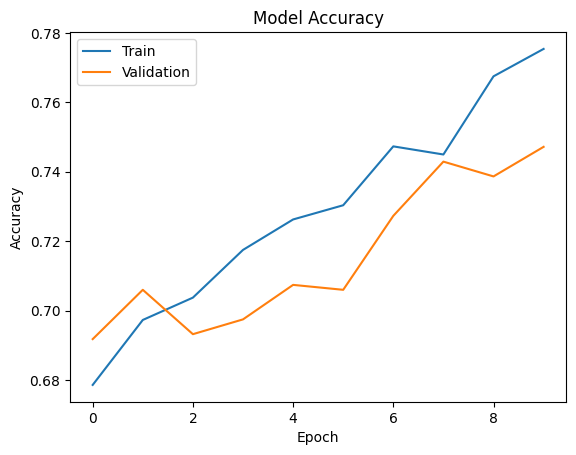

In [ ]:
import matplotlib.pyplot as plt


# Plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.show()


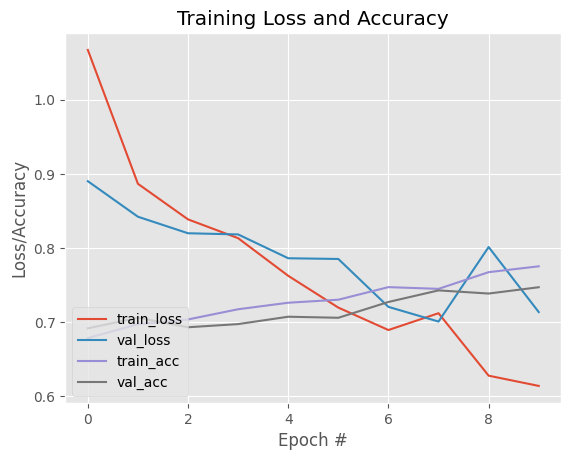

In [ ]:
#To plot the training loss and accuracy, as well as the validation loss and accuracy
#N values are plotted to avoid cluttering the plot. Adjust N according to the number of epochs you have trained your model for.
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history['loss'][:N], label="train_loss")
plt.plot(np.arange(0, N), history.history['val_loss'][:N], label="val_loss")
plt.plot(np.arange(0, N), history.history['accuracy'][:N], label="train_acc")  # Changed 'acc' to 'accuracy'
plt.plot(np.arange(0, N), history.history['val_accuracy'][:N], label="val_acc")  # Changed 'acc' to 'accuracy'

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()


In [ ]:
#good practice to ensure that the data generator is reset before making predictions to start from the beginning of the dataset.

test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples / test_data.batch_size, verbose=1)
y_pred = np.argmax(predictions, axis=1)


<ipython-input-23-d2fffe7c5fbf>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_data, steps=test_data.samples / test_data.batch_size, verbose=1)


836/836 [==============================] - 233s 278ms/step


In [ ]:
model.save('final_modelh.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load your trained model
model = load_model('Skin_Disease.h5')

# Define a mapping from class indices to class names
# Example class names (modify according to your model's training)
class_names = ['Class VASC', 'Class MEL', 'Class BKL', 'Class BCC', 'Class AKIEC', 'Class NV', 'Class DF']

# Define a function to preprocess the image
def preprocess_image(image):
    # Resize the image to match the input size expected by the model (224x224 for MobileNetV2)
    resized_image = cv2.resize(image, (224, 224))
    # Normalize the pixel values to [0, 1] (common for deep learning models)
    normalized_image = resized_image / 255.0
    return normalized_image

# Define a function to make predictions using an image path
def predict_image(image_path, model):
    # Load the image from the path
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at: {image_path}")

    # Preprocess the image (resize, normalize, etc.)
    processed_image = preprocess_image(image)

    # Expand dimensions to match the model's expected input shape
    processed_image = np.expand_dims(processed_image, axis=0)

    # Make predictions
    predictions = model.predict(processed_image)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get the corresponding class name using the class mapping
    predicted_class_name = class_names[predicted_class_index]

    # Return the predicted class name and probabilities
    return predicted_class_name, predictions

# Example usage
image_path = '/content/drive/MyDrive/Dataset/HAM10000_Images/ISIC_0024893.jpg'

try:
    predicted_class_name, predictions = predict_image(image_path, model)
    print("Predicted class:", predicted_class_name)  # Display the predicted class name
    print("Predictions:", predictions)  # Display raw probabilities for each class
except FileNotFoundError as e:
    print("Error:", e)


1/1 [==============================] - 0s 84ms/step
Predicted class: Class BKL
Predictions: [[9.9938847e-03 6.4643311e-05 7.1600735e-01 5.0034288e-07 7.9005934e-02
  1.9492771e-01 3.4627302e-15]]
